In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fantasy-basketball-average-draft-positioni/FantasyPros_2021_Overall_NBA_ADP_Rankings.csv


In [2]:
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from scipy.stats import zscore
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
!pip install espn_api
from espn_api.basketball import League

import requests
from bs4 import BeautifulSoup


  Preparing metadata (setup.py) ... - done
  Created wheel for espn-api: filename=espn_api-0.19.3-py3-none-any.whl size=43489 sha256=cf2722bdabed60ec0b35aa213229a28e62a0f570aefe2664d7e278aaed2a89db
  Stored in directory: /root/.cache/pip/wheels/25/6d/cb/a5695f2f6722751f3067e6112cfe047d1061e09607d92e861f
Successfully built espn-api


In [4]:
url = 'https://www.basketball-reference.com/leagues/NBA_2022_per_game.html'
page = requests.get(url)

In [5]:
soup = BeautifulSoup(page.content, 'html.parser')

table = soup.find_all(class_ = 'full_table')

In [6]:
head = soup.find(class_ = 'thead')

column_names_raw = [head.text for item in head][0]

column_names_clean = column_names_raw.replace('\n', ',').split(',')[2:-1]


In [7]:
players = []

for i in range(len(table)):
    player_ = []
    
    for td in table[i].find_all("td"):
        player_.append(td.text)
    
    players.append(player_)
player_stats = pd.DataFrame(players, columns = column_names_clean).set_index('Player')
player_stats.index = player_stats.index.str.replace('*', '')

player_stats.reset_index(inplace = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # This is added back by InteractiveShellApp.init_path()


In [8]:
fantasy_cats = ['MP','FG', 'FGA','FG%','3P', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

player_stats = player_stats.astype('float', errors = 'ignore')

percent_list = ['FG%', '3P%', '2P%', 'eFG%', 'FT%']
percent_stats = player_stats[percent_list].apply(lambda x: "0" + x).astype('float')


player_stats.drop(percent_list, errors = 'ignore')
player_stats[percent_list] = percent_stats

In [9]:
player_stats.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa,C,22.0,TOR,73.0,28.0,23.6,3.6,8.3,0.439,0.8,2.1,0.359,2.9,6.1,0.468,0.486,1.1,1.8,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,Steven Adams,C,28.0,MEM,76.0,75.0,26.3,2.8,5.1,0.547,0.0,0.0,0.000,2.8,5.0,0.548,0.547,1.4,2.6,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,Bam Adebayo,C,24.0,MIA,56.0,56.0,32.6,7.3,13.0,0.557,0.0,0.1,0.000,7.3,12.9,0.562,0.557,4.6,6.1,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,Santi Aldama,PF,21.0,MEM,32.0,0.0,11.3,1.7,4.1,0.402,0.2,1.5,0.125,1.5,2.6,0.560,0.424,0.6,1.0,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,LaMarcus Aldridge,C,36.0,BRK,47.0,12.0,22.3,5.4,9.7,0.550,0.3,1.0,0.304,5.1,8.8,0.578,0.566,1.9,2.2,0.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9


In [10]:
league = League(league_id=155022057, year=2022, espn_s2 = 'AEAccgqxg7aWTUXJBVz9VECyQSPj%2Fd07pBz5JekblDeqokl3qn3G66tweST3UXyF4CnwBM5517Ck7%2BlvM33jErRfA3y6fQdSC%2F8hr3lBjKIXXOheVPx%2FQj%2BcrZM1jnDGXf3vk8wchKUJATPJRbjk2CzMz3fAIhvTpBZjGWeFjAC2iu%2FtEO2F6gR6swfHAC9ke1JM%2FYkD25W0%2FcXC9qXwUKR6zPjfpshKjmY3xcTEAzAJGxOulKCAN1hVEahuui7af0S8dG0rzd39LNMGJ3tltX8I', swid = '{1AC82508-AC54-412A-9086-0F6C39344835}')

league

League(155022057, 2022)

In [11]:
lineup1 = []
teams1 = []
box = league.box_scores(1)
listteams = box
for x in range(len(listteams)):
    lineup1.append(box[x].home_lineup)
    lineup1.append(box[x].away_lineup)
    teams1.append(box[x].home_team)
    teams1.append(box[x].away_team)

cleanteamlist = [str(x).replace('Team(', '') for x in teams1]
cleanteamlist = [str(x).replace(')', '') for x in cleanteamlist]


In [12]:
cleanplayerlist = []
for z in range(len(lineup1)):
    cleaned_list1 = [str(w).replace('Player(', '') for w in lineup1[z]]
    cleaned_list2 = [str(x).replace(', points:0)', '') for x in cleaned_list1]
    cleanplayerlist.append(cleaned_list2)


In [13]:
#cleanplayerlist = []
#for team in teamlist:
#    cleaned_list1 = [str(w).replace('Player(', '') for w in team.roster]
#    cleaned_list2 = [str(x).replace(')', '') for x in cleaned_list1]
#    cleanplayerlist.append(cleaned_list2)

In [14]:
team_roster = pd.DataFrame()
team_roster['Team'] = cleanteamlist
team_roster.explode('Team')
team_roster['Player'] = cleanplayerlist
team_roster = team_roster.explode('Player', ignore_index = True)

team_roster.head()

,Team,Player
0,Teenage Mutant Ninja Poeltl,Ivica Zubac
1,Teenage Mutant Ninja Poeltl,Christian Wood
2,Teenage Mutant Ninja Poeltl,Ja Morant
3,Teenage Mutant Ninja Poeltl,Buddy Hield
4,Teenage Mutant Ninja Poeltl,Jordan Poole


In [15]:
def convert_cum_stats(df):
    cum_fantasy_cats = ['G','FG','FGA', '3P', 'FT', 'FTA', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']
    percent_cats = df[['FG%','FT%']]
    player_info = df[['Player', 'Pos', 'Age', 'Tm']]
    
    cum_fantasy_stats = df[cum_fantasy_cats[1:]].multiply(df['G'], axis = 'index').round(0)
    
    cum_player_stats = percent_cats.merge(cum_fantasy_stats, left_index = True,right_index = True)
    cum_player_stats = player_info.merge(cum_player_stats, left_index = True,right_index = True)
    return cum_player_stats


In [16]:
def calculate_zscore(df):
    cum_player_stats = df

    mean_FGp = sum(cum_player_stats['FG'])/sum(cum_player_stats['FGA'])
    mean_FTp = sum(cum_player_stats['FT'])/sum(cum_player_stats['FTA'])

    cum_player_stats['mFG%'] = (cum_player_stats['FG%'] - mean_FGp)*cum_player_stats['FGA']
    cum_player_stats['mFT%'] = (cum_player_stats['FT%'] - mean_FTp)*cum_player_stats['FTA']

    cum_player_stats['zFG%'] = zscore(cum_player_stats['mFG%'])
    cum_player_stats['zFT%'] = zscore(cum_player_stats['mFT%'])
    cum_player_stats['z3P'] = zscore(cum_player_stats['3P'])
    cum_player_stats['zPTS'] = zscore(cum_player_stats['PTS'])
    cum_player_stats['zTRB'] = zscore(cum_player_stats['TRB'])
    cum_player_stats['zAST'] = zscore(cum_player_stats['AST'])
    cum_player_stats['zSTL'] = zscore(cum_player_stats['STL'])
    cum_player_stats['zBLK'] = zscore(cum_player_stats['BLK'])
    cum_player_stats['zTOV'] = -zscore(cum_player_stats['TOV'])
    
    z_fantasy_cats = ['zFG%', 'z3P', 'zFT%', 'zTRB', 'zAST', 'zSTL', 'zBLK', 'zTOV', 'zPTS']
    cum_player_stats['zTotal'] = cum_player_stats[z_fantasy_cats].sum(axis = 1, numeric_only = True)
    
    cum_player_stats.sort_values('zTotal', inplace = True, ascending = False)
    cum_player_stats = cum_player_stats.reset_index(drop = True)
    
    return cum_player_stats

In [17]:
cum_player_stats = convert_cum_stats(player_stats)
player_z = calculate_zscore(cum_player_stats)

top400 = player_z.loc[:399 , :].copy()

top400.head(25)

,Player,Pos,Age,Tm,FG%,FT%,FG,FGA,3P,FT,FTA,TRB,AST,STL,BLK,TOV,PTS,mFG%,mFT%,zFG%,zFT%,z3P,zPTS,zTRB,zAST,zSTL,zBLK,zTOV,zTotal
0,Nikola Jokić,C,26.0,DEN,0.583,0.810,762.0,1310.0,96.0,377.0,466.0,1021.0,585.0,111.0,67.0,281.0,2005.0,159.640368,16.222510,5.760428,1.363015,0.761589,3.404734,4.673136,3.969540,2.779466,2.008298,-4.012545,20.707661
1,Joel Embiid,C,27.0,PHI,0.499,0.814,666.0,1333.0,95.0,653.0,802.0,796.0,286.0,75.0,102.0,211.0,2081.0,50.471214,31.127427,1.821848,2.611131,0.744822,3.571128,3.421691,1.520745,1.528215,3.477843,-2.779667,15.917755
2,Trae Young,PG,23.0,ATL,0.460,0.904,714.0,1543.0,236.0,502.0,555.0,281.0,737.0,68.0,8.0,304.0,2158.0,-1.754582,71.490801,-0.062343,5.991100,3.108990,3.739711,0.557273,5.214412,1.284916,-0.468936,-4.417633,14.947490
3,Karl-Anthony Towns,C,26.0,MIN,0.529,0.822,644.0,1214.0,148.0,385.0,466.0,725.0,266.0,74.0,81.0,229.0,1820.0,82.385532,21.814510,2.973245,1.831281,1.633481,2.999698,3.026791,1.356946,1.493458,2.596116,-3.096693,14.814323
4,DeMar DeRozan,PF,32.0,CHI,0.504,0.877,775.0,1535.0,53.0,517.0,593.0,395.0,372.0,68.0,23.0,182.0,2120.0,65.794515,60.374666,2.374678,5.060251,0.040601,3.656514,1.191339,2.225081,1.284916,0.160869,-2.268903,13.725347
5,Kevin Durant,PF,33.0,BRK,0.518,0.910,578.0,1116.0,116.0,374.0,407.0,407.0,352.0,50.0,50.0,192.0,1644.0,63.458970,54.868587,2.290417,4.599180,1.096932,2.614366,1.258082,2.061282,0.659291,1.294518,-2.445029,13.429040
6,Jayson Tatum,SF,23.0,BOS,0.453,0.853,707.0,1566.0,228.0,403.0,471.0,608.0,334.0,76.0,46.0,220.0,2044.0,-12.742736,36.649571,-0.458771,3.073547,2.974853,3.490121,2.376040,1.913863,1.562972,1.126570,-2.938180,13.121014
7,Tyrese Haliburton,SG-PG,21.0,TOT,0.473,0.842,431.0,909.0,162.0,162.0,192.0,308.0,631.0,131.0,46.0,200.0,1178.0,10.783355,12.827953,0.389998,1.078760,1.868221,1.594112,0.707447,4.346278,3.474605,1.126570,-2.585929,12.000062
8,Stephen Curry,PG,33.0,GSW,0.437,0.923,538.0,1222.0,288.0,275.0,301.0,333.0,403.0,83.0,26.0,205.0,1632.0,-29.495565,44.491488,-1.063176,3.730217,3.980881,2.588093,0.846496,2.478969,1.806271,0.286830,-2.673992,11.980591
9,Giannis Antetokounmpo,PF,27.0,MIL,0.553,0.722,690.0,1246.0,74.0,556.0,764.0,777.0,389.0,74.0,94.0,221.0,2003.0,114.461144,-40.635438,4.130462,-3.398185,0.392712,3.400356,3.316014,2.364310,1.493458,3.141947,-2.955792,11.885280


In [18]:
top400z = calculate_zscore(top400)


top400z = top400z.drop(columns = top400z.iloc[:,2:19])

top400z.head(25)

,Player,Pos,zFG%,zFT%,z3P,zPTS,zTRB,zAST,zSTL,zBLK,zTOV,zTotal
0,Nikola Jokić,C,4.625413,1.006065,0.361611,3.115316,4.440313,3.448134,2.555260,1.559937,-3.629577,17.482470
1,Joel Embiid,C,1.398706,1.949692,0.345298,3.290997,3.124483,1.098201,1.162379,2.956032,-2.383844,12.941944
2,Karl-Anthony Towns,C,2.349824,1.392417,1.209869,2.687671,2.709265,0.941015,1.123687,2.118375,-2.704175,11.827949
3,Trae Young,PG,-0.158803,4.801744,2.645384,3.468989,0.112694,4.642748,0.891541,-0.793481,-4.038889,11.571927
4,Jayson Tatum,SF,-0.485021,2.416093,2.514882,3.205468,2.025033,1.475447,1.201070,0.722280,-2.544009,10.531244
5,DeMar DeRozan,PF,1.837308,4.023983,-0.339834,3.381149,0.779381,1.774101,0.891541,-0.195154,-1.867754,10.284721
6,Kevin Durant,PF,1.797523,3.691261,0.687864,2.280831,0.849558,1.616915,0.195100,0.881834,-2.045716,9.955170
7,Tyrese Haliburton,SG-PG,0.255798,0.841793,1.438247,1.203629,0.270593,3.809662,3.329083,0.722280,-2.188086,9.682998
8,Giannis Antetokounmpo,PF,3.295179,-2.998679,0.002732,3.110693,3.013368,1.907709,1.123687,2.636925,-2.561805,9.529809
9,Stephen Curry,PG,-0.955954,3.001485,3.493642,2.253092,0.416797,2.017740,1.471908,-0.075489,-2.277066,9.346153


In [19]:
!pip install Unidecode

In [20]:
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    utf8 = only_ascii.decode('utf-8', 'ignore')
    return utf8
top400z['Player'] = top400z['Player'].apply(remove_accents)

#top250z['Player'] = top250z['Player'].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
top400z.head()

,Player,Pos,zFG%,zFT%,z3P,zPTS,zTRB,zAST,zSTL,zBLK,zTOV,zTotal
0,Nikola Jokic,C,4.625413,1.006065,0.361611,3.115316,4.440313,3.448134,2.555260,1.559937,-3.629577,17.482470
1,Joel Embiid,C,1.398706,1.949692,0.345298,3.290997,3.124483,1.098201,1.162379,2.956032,-2.383844,12.941944
2,Karl-Anthony Towns,C,2.349824,1.392417,1.209869,2.687671,2.709265,0.941015,1.123687,2.118375,-2.704175,11.827949
3,Trae Young,PG,-0.158803,4.801744,2.645384,3.468989,0.112694,4.642748,0.891541,-0.793481,-4.038889,11.571927
4,Jayson Tatum,SF,-0.485021,2.416093,2.514882,3.205468,2.025033,1.475447,1.201070,0.722280,-2.544009,10.531244


In [21]:
!pip install fuzzywuzzy

In [22]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=2):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1

In [23]:
fantasy_stats = team_roster.merge(top400z,how = 'left', on = 'Player')
fantasy_stats.head()

,Team,Player,Pos,zFG%,zFT%,z3P,zPTS,zTRB,zAST,zSTL,zBLK,zTOV,zTotal
0,Teenage Mutant Ninja Poeltl,Ivica Zubac,C,2.372155,-0.812806,-1.204405,0.290550,2.247262,-0.190726,-0.269194,1.918933,-0.657614,3.694157
1,Teenage Mutant Ninja Poeltl,Christian Wood,C,0.972254,-3.582041,0.899929,1.293781,2.487036,0.076491,0.349865,1.599826,-0.924556,3.172583
2,Teenage Mutant Ninja Poeltl,Ja Morant,PG,1.023846,-0.509710,0.198484,2.091280,0.370011,1.852694,0.891541,-0.195154,-2.081308,3.641684
3,Teenage Mutant Ninja Poeltl,Buddy Hield,SG,-1.871242,0.858909,3.020575,1.402426,0.551304,0.634502,1.084996,-0.155266,-1.369461,4.156742
4,Teenage Mutant Ninja Poeltl,Jordan Poole,SG,-0.482849,2.689782,2.270192,1.730672,-0.021814,1.239668,0.620703,-0.195154,-2.010124,5.841077


In [24]:
z_fantasy_cats = ['zFG%', 'z3P', 'zFT%', 'zTRB', 'zAST', 'zSTL', 'zBLK', 'zTOV', 'zPTS', 'zTotal']
zteam = fantasy_stats.groupby('Team')[z_fantasy_cats].sum().reset_index()
#zteam = pd.melt(zteam, value_vars = z_fantasy_cats)
zteam.head(10)

,Team,zFG%,z3P,zFT%,zTRB,zAST,zSTL,zBLK,zTOV,zPTS,zTotal
0,Home Dipo,1.892709,6.962937,1.752154,10.064463,9.203701,7.678934,9.381063,-14.797128,12.042512,44.181345
1,Ligma Ball Bro,3.003393,-2.025339,1.163933,10.228211,7.969790,4.080658,7.825414,-9.831992,6.889973,29.304039
2,Lowry Expectations,9.988383,8.270682,2.272692,14.703612,17.265248,14.141999,3.282420,-15.953035,18.130536,72.102538
3,Tacko Tuesday,2.183713,3.618842,2.235638,5.766085,10.280426,8.762286,10.936712,-7.607469,8.766986,44.943218
4,Teenage Mutant Ninja Poeltl,4.534896,7.748677,-1.381733,11.639190,11.905200,6.790682,9.425239,-16.077608,16.246588,50.831132
5,Tune Squad,3.940782,7.996100,-5.425319,13.547261,13.003401,9.462015,9.509304,-17.375884,16.054015,50.711675
6,VANCOUVER WhamBamThankyMa,-0.710925,8.058618,9.873153,8.463653,11.488657,7.603196,4.359407,-16.148793,14.159220,47.146187
7,Wardell's Shaucy Kitchen,7.931908,3.526430,4.709882,8.155281,7.957726,9.926309,4.762580,-8.513384,10.973135,49.429867


<AxesSubplot:ylabel='Team'>

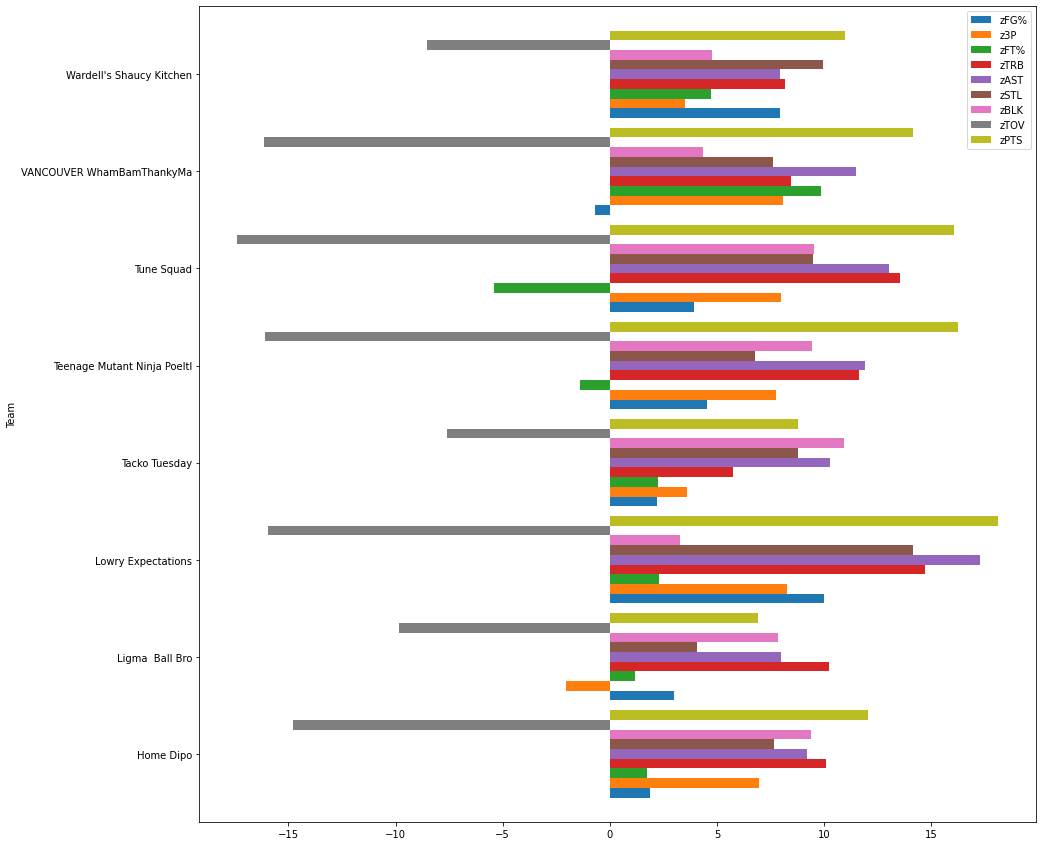

In [25]:
zteam.plot(x = 'Team', y = z_fantasy_cats[:-1], kind = 'barh', figsize = (15,15), width = 0.9)

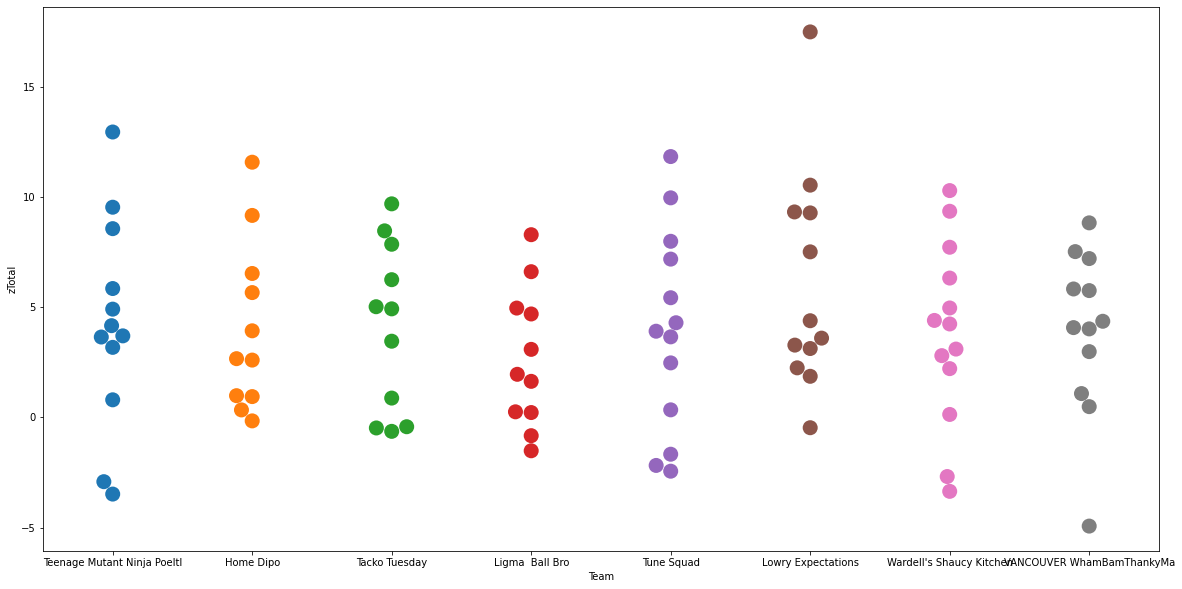

In [26]:
plt.figure(figsize = (20,10))
ax = sns.swarmplot(data = fantasy_stats, x = 'Team', y = 'zTotal', size = 15)

In [27]:
cat10 = ['FG%','FT%','3P','PTS','TRB','AST','STL','BLK','TOV','Total']
def team_rankings(zteam):
    zteam['FG%'] = zteam['zFG%'].rank(ascending = True)
    zteam['FT%'] = zteam['zFT%'].rank(ascending = True)
    zteam['3P'] = zteam['z3P'].rank(ascending = True)
    zteam['PTS'] = zteam['zPTS'].rank(ascending = True)
    zteam['TRB'] = zteam['zTRB'].rank(ascending = True)
    zteam['AST'] = zteam['zAST'].rank(ascending = True)
    zteam['STL'] = zteam['zSTL'].rank(ascending = True)
    zteam['BLK'] = zteam['zBLK'].rank(ascending = True)
    zteam['TOV'] = zteam['zTOV'].rank(ascending = True)
    zteam['Total'] = zteam['zTotal'].rank(ascending = True)

    new = zteam[['Team']+cat10].copy().sort_values('Total', ascending = False)
    return new


rankings = team_rankings(zteam)
rankings.head(9)


,Team,FG%,FT%,3P,PTS,TRB,AST,STL,BLK,TOV,Total
2,Lowry Expectations,8.0,6.0,8.0,8.0,8.0,8.0,8.0,1.0,4.0,8.0
4,Teenage Mutant Ninja Poeltl,6.0,2.0,5.0,7.0,6.0,6.0,2.0,6.0,3.0,7.0
5,Tune Squad,5.0,1.0,6.0,6.0,7.0,7.0,6.0,7.0,1.0,6.0
7,Wardell's Shaucy Kitchen,7.0,7.0,2.0,3.0,2.0,1.0,7.0,3.0,7.0,5.0
6,VANCOUVER WhamBamThankyMa,1.0,8.0,7.0,5.0,3.0,5.0,3.0,2.0,2.0,4.0
3,Tacko Tuesday,3.0,5.0,3.0,2.0,1.0,4.0,5.0,8.0,8.0,3.0
0,Home Dipo,2.0,4.0,4.0,4.0,4.0,3.0,4.0,5.0,5.0,2.0
1,Ligma Ball Bro,4.0,3.0,1.0,1.0,5.0,2.0,1.0,4.0,6.0,1.0


In [28]:
len(league.recent_activity(200)) #number of transactions

159

In [29]:
transactions = league.recent_activity(200)
